# Confidence Intervals

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload

# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

# Exercise 1: UNCERTAINTY FROM BOOTSTRAPPING METHOD

The uncertainty estimate from
bootstrapping: uses multiple Monte
Carlo generated samples and the bestfit values of those samples to build a
distribution. The ‘width’ of the ensuing
best-fit values from the Monte Carlo
constitutes the uncertainties

#### Defining the likelihood functions (similiar to exercise 2 and 3 in week 2)
New x range (-0.95 .. 0.95) 

In [9]:
def likelihood(x, alpha, beta):
    # transform function into pdf (normalize!) and include limits for x (-1..1)
    func = 1 + alpha*x + beta*x**2 
    func_int = 0.571583 * beta + 1.9 
    pdf = func / func_int
    pdf = np.where(np.abs(x) <= 0.95, pdf, 0.) 
    return pdf

def loglikelihood(x, alpha, beta):
    return np.sum(np.log(likelihood(x, alpha, beta)), axis = 1)

#### Monte Carlo simulation

**1 MC trial with 2000 samples in each for visual inspection of the fit**

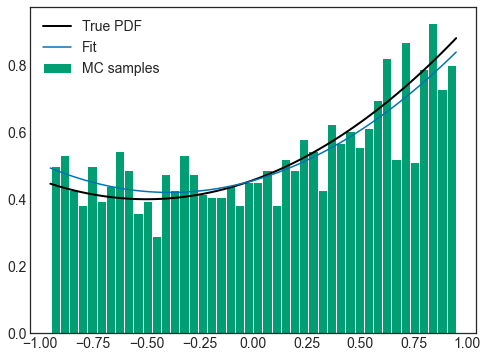

In [10]:
xrange = np.linspace(-0.95, 0.95, 100)
alpha, beta, n_samples = 0.5, 0.5, 2000

x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = aas.gen_MC(xrange, likelihood, [alpha, beta], n_samples)
par, par_err = aas.llh_fit(x_accept, likelihood, [0.3, 0.6], ['alpha', 'beta'], [(0,2), (0,2)])

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(x_accept, bins = 44, density = True, color=color[2], label = 'MC samples') 
ax.plot(xrange, pdf_curve, ls = '-', color = 'black', lw = 2, label = r'True PDF')
ax.plot(xrange, likelihood(xrange, par[0], par[1]), color = color[0], label = 'Fit')
ax.legend();

**500 MC trials with 2000 samples in each**

In [11]:
# define xrange, parameters and number of samples
xrange = np.linspace(-0.95, 0.95, 100)
alpha, beta = 0.5, 0.5
n_samples, n_trials = 2000, 500

alpha_fit, beta_fit = [], []

# run MC and fit MC samples
for i in range(n_trials):
    x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = aas.gen_MC(xrange, likelihood, [alpha, beta], n_samples)
    par, par_err = aas.llh_fit(x_accept, likelihood, [alpha, beta], ['alpha', 'beta'], [(0,1), (0,1)])
    alpha_fit = np.append(alpha_fit, par[0])
    beta_fit = np.append(beta_fit, par[1])

**The distribution of the two parameters alpha and beta**

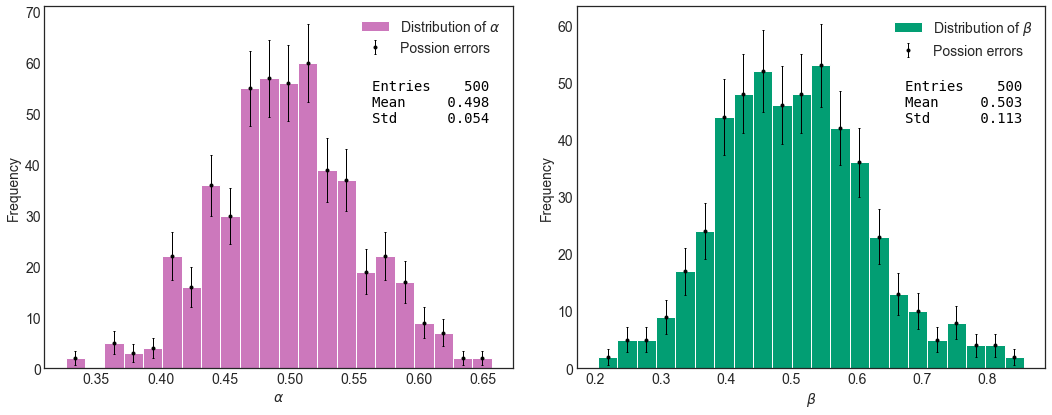

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), tight_layout=True)
aas.plot_hist(alpha_fit, min(alpha_fit), max(alpha_fit), 22, ax1, xlabel=r'$\alpha$', histlabel=r'Distribution of $\alpha$', 
             d_xy = [0.7, 0.80], color = color[4])

aas.plot_hist(beta_fit, min(beta_fit), max(beta_fit), 22, ax2, xlabel=r'$\beta$', histlabel=r'Distribution of $\beta$', 
             d_xy = [0.7, 0.8], color = color[2])

**A 2d histogram and scatter plot of the parameters alpha and beta**

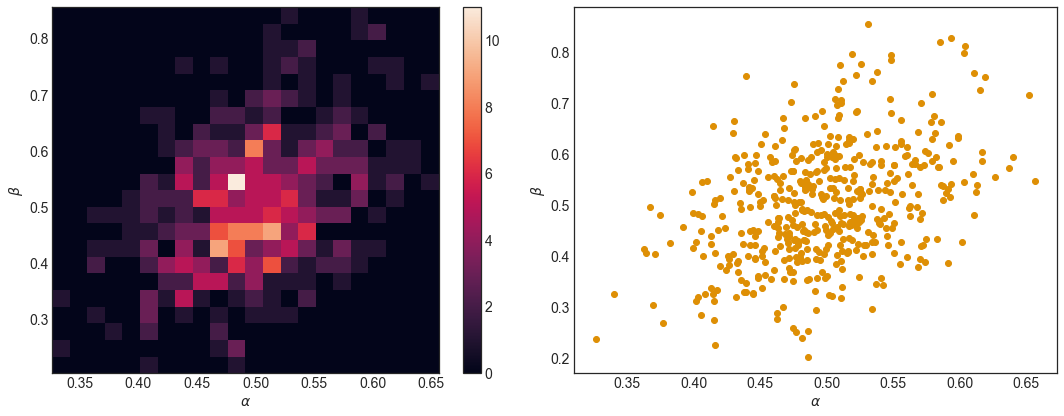

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), tight_layout=True)
hist = ax1.hist2d(alpha_fit, beta_fit, 22)
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel(r'$\beta$')
fig.colorbar(hist[3], ax=ax1)

ax2.scatter(alpha_fit, beta_fit, color = color[1])
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel(r'$\beta$');

In [14]:
alpha_mean, alpha_rmse = np.mean(alpha_fit), np.std(alpha_fit)
beta_mean, beta_rmse = np.mean(beta_fit), np.std(beta_fit)

print('Estimators \nAlpha mean =', round(alpha_mean, 4), '\nAlpha RMSE =', round(alpha_rmse, 4),
      '\n\nBeta mean =', round(beta_mean, 4), '\nBeta RMSE =', round(beta_rmse, 4))

Estimators 
Alpha mean = 0.498 
Alpha RMSE = 0.0543 

Beta mean = 0.5034 
Beta RMSE = 0.1128


## Exercise 1b

### Confidence levels

**Determine the confidence levels by sorting the values of alpha and beta and finding the value corresponding to the lower and upper limit**

In [15]:
def confidence_level(data, sigma = 1):
    
    if sigma == 1: frac = 0.6827 / 2
    if sigma == 2: frac = 0.9545 / 2
    if sigma == 3: frac = 0.9973 / 2
    
    n = len(data)
    data_mean = np.mean(data)
    data_sorted = sorted(data)
    
    # index for lower and higher limit
    low_lim = int(n * (0.5 - frac) + 0.5)
    high_lim = int(n - low_lim + 0.5)
    
    # confidence levels
    data_low_sigma = data_mean - data_sorted[low_lim]
    data_high_sigma = - (data_mean - data_sorted[high_lim])
    
    return data_mean, data_low_sigma, data_high_sigma

In [16]:
alpha_cl = confidence_level(alpha_fit)
beta_cl = confidence_level(beta_fit)

print('Alpha =', round(alpha_cl[0], 3), '-', round(alpha_cl[1], 3), '+', round(alpha_cl[2], 3))
print('Beta =', round(beta_cl[0], 3), '-', round(beta_cl[1], 3), '+', round(beta_cl[2], 3))

Alpha = 0.498 - 0.053 + 0.053
Beta = 0.503 - 0.108 + 0.105


### Repeat exercise 1b but know: Fix α=0.5, and only fit for β, i.e. α is now a constant

#### Define new likelihood

In [17]:
def likelihood_new(x, beta):
    # transform function into pdf (normalize!) and include limits for x (-0.95..0.95)
    alpha = 0.5
    func = 1 + alpha*x + beta*x**2 
    func_int = 0.571583 * beta + 1.9 
    pdf = func / func_int
    pdf = np.where(np.abs(x) <= 0.95, pdf, 0.) 
    return pdf

#### Monte Carlo simulation

In [18]:
# define xrange, parameters and number of samples
xrange = np.linspace(-0.95, 0.95, 100)
beta = 0.5
n_samples, n_trials = 2000, 500

beta_fit = []

# run MC and fit MC samples
for i in range(n_trials):
    x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = aas.gen_MC(xrange, likelihood_new, [beta], n_samples)
    par, par_err = aas.llh_fit(x_accept, likelihood_new, [beta], ['beta'], [(0,1)])
    beta_fit = np.append(beta_fit, par[0])

In [19]:
beta_mean, beta_rmse = np.mean(beta_fit), np.std(beta_fit)
print('Estimators \nBeta mean =', round(beta_mean, 4), '\nBeta RMSE =', round(beta_rmse, 4))

Estimators 
Beta mean = 0.5016 
Beta RMSE = 0.1032


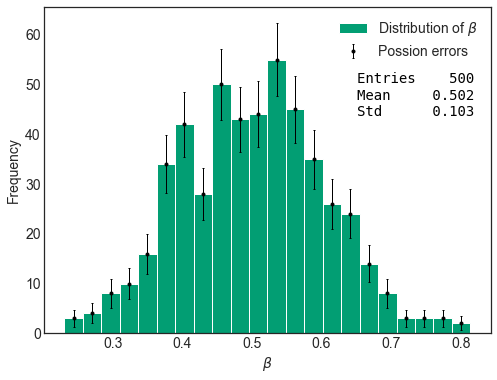

In [20]:
fig, ax = plt.subplots(figsize = (8,6))
aas.plot_hist(beta_fit, min(beta_fit), max(beta_fit), 22, ax, xlabel=r'$\beta$', histlabel=r'Distribution of $\beta$', 
             d_xy = [0.7, 0.8], color = color[2])

#### 1 sigma confidence level for beta

In [21]:
beta_cl = confidence_level(beta_fit)
print('Beta =', round(beta_cl[0], 3), '-', round(beta_cl[1], 3), '+', round(beta_cl[2], 3))

Beta = 0.502 - 0.108 + 0.105


When alpha was a parameter, the 1 sigma confidence levels for beta was [0.402-622]. When alpha is a constant the 1 sigma confidence level is [0.421-0.602]. 

### Repeat with a new range of the -0.9 ≤ x ≤ 0.85

#### When the limits change the normalization constant changes! New likelihood

In [22]:
def likelihood_new2(x, beta):
    # transform function into pdf (normalize!) and include limits for x (-0.90..0.85)
    alpha = 0.5
    func = 1 + alpha*x + beta*x**2 
    func_int = -0.04375*alpha + 0.447708*beta + 1.75
    pdf = func / func_int
    #pdf = np.where(np.abs(x) <= 0.95, pdf, 0.) 
    return pdf

In [23]:
# define xrange, parameters and number of samples
xrange = np.linspace(-0.90, 0.85, 100)
beta = 0.5
n_samples, n_trials = 2000, 500

beta_fit = []

# run MC and fit MC samples
for i in range(n_trials):
    x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = aas.gen_MC(xrange, likelihood_new2, [beta], n_samples)
    par, par_err = aas.llh_fit(x_accept, likelihood_new2, [beta], ['beta'], [(0,1)])
    beta_fit = np.append(beta_fit, par[0])

In [24]:
beta_mean, beta_rmse = np.mean(beta_fit), np.std(beta_fit)
print('Estimators \nBeta mean =', round(beta_mean, 4), '\nBeta RMSE =', round(beta_rmse, 4))

Estimators 
Beta mean = 0.4953 
Beta RMSE = 0.1117


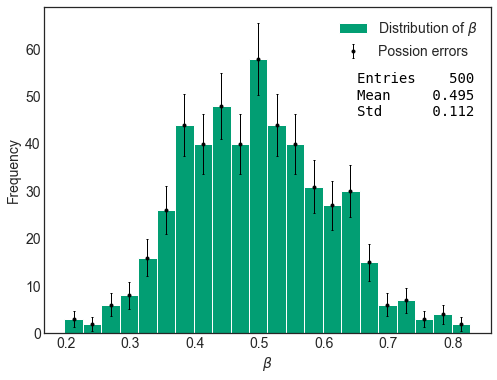

In [25]:
fig, ax = plt.subplots(figsize = (8,6))
aas.plot_hist(beta_fit, min(beta_fit), max(beta_fit), 22, ax, xlabel=r'$\beta$', histlabel=r'Distribution of $\beta$', 
             d_xy = [0.7, 0.8], color = color[2])

In [26]:
beta_cl = confidence_level(beta_fit)
print('Beta =', round(beta_cl[0], 3), '-', round(beta_cl[1], 3), '+', round(beta_cl[2], 3))

Beta = 0.495 - 0.114 + 0.118


# Exercise 1c: UNCERTAINTY FROM LIKELIHOOD

The uncertainty estimate from
likelihood(s): get the best-fit of a
parameter. Establish the value of the
parameter where the LLH difference to
the best-fit point is equal to the critical
value for the number of fit parameters

**One single trial of a MC simulation**

In [42]:
# define xrange, parameters and number of samples
xrange = np.linspace(-0.90, 0.85, 100)
beta = 0.5
n_samples, n_trials = 2000, 1

beta_fit = []

# run MC and fit MC samples
x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = aas.gen_MC(xrange, likelihood_new2, [beta], n_samples)
par, par_err = aas.llh_fit(x_accept, likelihood_new2, [beta], ['beta'], [(0,1)])
beta_fit = np.append(beta_fit, par[0])

In [43]:
def llh(data, pdf, pars):
    'Negative log likelikehood given data, pdf and parameters'
    return - np.sum(np.log(pdf(data, *pars)))

def find_closest(data, value):
    'Function for finding the index of the element in array that is closets to the value'
    data_left = data[:np.argmin(data)]
    data_right = data[np.argmin(data):]
    diff_left = abs(np.array(data_left)-value)
    diff_right = abs(np.array(data_right)-value)
    idx_left = np.argmin(diff_left)
    idx_right = np.argmin(diff_right)
    return idx_left, np.argmin(data) + idx_right

In [44]:
beta_range = np.linspace(0, 1, 1000)
llh_vals = []

for i in beta_range:
    llh_vals.append(llh(x_accept, likelihood_new2, [i]))
    
llh_min = min(llh_vals)
beta_best = beta_range[np.argmin(llh_vals)]
idx1, idx2 = find_closest(llh_vals, llh_min+1/2)

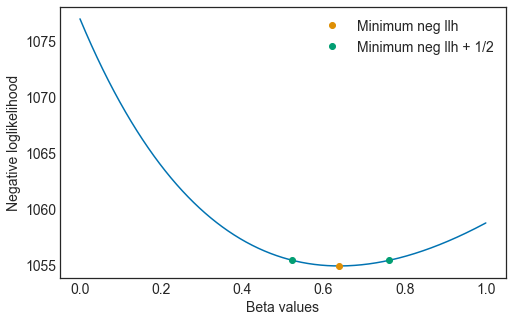

In [47]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(beta_range, llh_vals)
ax.plot(beta_best, llh_min, 'o', label = 'Minimum neg llh')
ax.plot(beta_range[idx1], llh_vals[idx1], 'o', color=color[2], label = 'Minimum neg llh + 1/2')
ax.plot(beta_range[idx2], llh_vals[idx2], 'o', color=color[2])
ax.set_xlabel('Beta values')
ax.set_ylabel('Negative loglikelihood')
ax.legend();

**Check to see if is asymmetric, i.e. ,
for this problem when using the likelihood prescription to
estimate the uncertainty**

In [46]:
print('Beta =',round(beta_best,3),'-',round(beta_best-beta_range[idx1],3),'+',-(round(beta_best-beta_range[idx2],3)))

Beta = 0.639 - 0.115 + 0.123


# Exercise 2

Using the same function and 𝝰=0.5 and 𝝱=0.5 as Exercise
#1, find the MLE values for a single Monte Carlo sample w/
2000 points

#### Defining likelihood

In [32]:
def likelihood(x, alpha, beta):
    # transform function into pdf (normalize!) and include limits for x (-1..1)
    func = 1 + alpha*x + beta*x**2 
    func_int = 2+(2*beta/3) 
    pdf = func / func_int
    pdf = np.where(np.abs(x) <= 1, pdf, 0.) 
    return pdf

#### **Define ranges and parameters and generate MC samples:**

In [52]:
xrange = np.linspace(-1, 1, 100)
alpha, beta = 0.6, 0.5
parms = [alpha, beta]
n_samples = 2000
x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = aas.gen_MC(xrange, likelihood, parms, n_samples)

In [53]:
# define the ranges for the likelihood landscape
alpha_range = beta_range = np.linspace(0,1,100)

par, par_err, alpha_step, beta_step = aas.llh_fit(x_accept, likelihood, [0.3, 0.3], ['alpha', 'beta'], step = True, 
                                         alpha_range = alpha_range, beta_range = beta_range)

In [68]:
def loglikelihood(x, mu, sigma):
    'POSITIVE log likelihood'
    return np.sum(np.log(likelihood(x, mu, sigma)), axis=1)

def rasterscan(x_samples, a_true, b_true, a_range, b_range, a_name, b_name, ax):
    # 2D grid with all possible combinations of mu-sigma pairs
    grid = np.array(list(itertools.product(a_range,b_range)))
    
    # breaking down the a-b values in the 2D grid into separate arrays and expanding their axes to enable
    # arithmetic operations with x_samples.
    a_from_grid = np.expand_dims(grid[:,0],axis=1)
    b_from_grid = np.expand_dims(grid[:,1],axis=1)
    
    # evaluating the log_likelihood for all points in grid
    scanned_llh = loglikelihood(x_samples, a_from_grid, b_from_grid)

    #after the scan, we find the index in the flat scanned_llh array that gives us the maximum likelihood
    ind_max_llh = np.argmax(scanned_llh)

    # PLOT RESULT    
    sc = ax.scatter(a_from_grid, b_from_grid, c = -2*(scanned_llh-max(scanned_llh)), marker = 's', s = 100, cmap = 'viridis', vmin=0, vmax=100)
    ax.plot(a_true, b_true, marker='*', color='red', markersize=15, ls='none', label = 'True value')

    #the maximum of the raster scan LLH
    ax.plot(a_from_grid[ind_max_llh], b_from_grid[ind_max_llh], marker = '*', ls='none',
            color = 'black',markersize = 15, label = 'Maximum LLH from the scan')
    
    contours = ax.contour(a_from_grid.reshape(len(a_range), len(b_range)),
                          b_from_grid.reshape(len(a_range), len(b_range)),
                          -2*(scanned_llh-max(scanned_llh)).reshape(len(a_range), len(b_range)),
                          [2.3, 6.18, 11.84], colors=['white', 'grey', 'black']) # 2.3, 4.5 and 6 are C.L. for distributions
                                                                          # with two parameters

    ax.legend(loc = (0.1,0.8), labelcolor='w') 
    ax.set_xlabel(a_name)
    ax.set_ylabel(b_name)

    cb = fig.colorbar(sc,label= r'$-2 \Delta$ LLH', ax=ax)
    #put_ticks(fig,ax)
    
    return [a_from_grid[ind_max_llh], b_from_grid[ind_max_llh]]
    

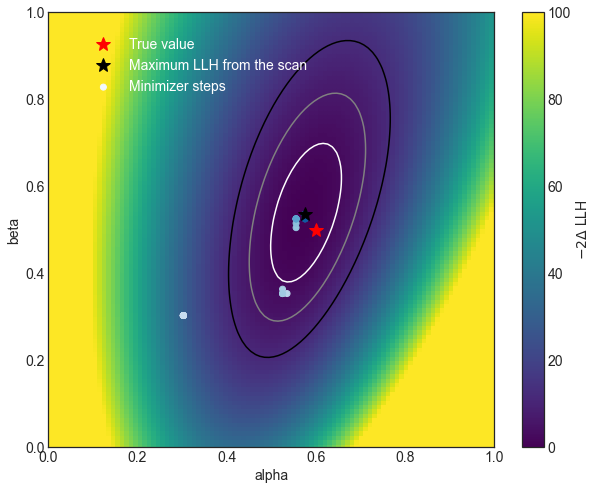

In [69]:
# color palette for the parameter steps taken
track_colors = sns.color_palette('Blues',len(alpha_step))

# plot result
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
rasterscan(x_accept, alpha, beta, alpha_range, beta_range, 'alpha', 'beta', ax)
ax.scatter(alpha_step, beta_step, color = track_colors, label = 'Minimizer steps')
ax.legend(loc = (0.08,0.8), labelcolor='w');

If you have **two parameters** and plot -2 $\Delta$ LLH you get the 1, 2, 3 sigma contours at [2.3, 6.18, 11.84]

If you have **two parameters** and plot $\Delta$ LLH you get the 1, 2, 3 sigma contours at [1.15, 3.09, 5.92] 

If you have **one parameter** and plot $\Delta$ LLH you get the 1, 2, 3 sigma contours at [0.5, 2.0, 4.5] 

# Exercise 3

There is a file posted on the class webpage which has two
columns of x numbers (not x and y, just x for 2 pseudoexperiments) corresponding to x over the range -1 ≤ x ≤ 1. Find the best-fit for the unknown alpha and beta

#### Defining likelihood

In [195]:
def likelihood(x, alpha, beta):
    # transform function into pdf (normalize!) and include limits for x (-1..1)
    func = 1 + alpha*x + beta*x**2 
    func_int = 2+(2*beta/3) 
    pdf = func / func_int
    pdf = np.where(np.abs(x) <= 1, pdf, 0.) 
    return pdf

In [196]:
data = np.genfromtxt('MLE_Variance_data.txt')
x1 = data[:,0]
x2 = data[:,1]

In [197]:
xrange = np.linspace(-1, 1, 100)

# define the ranges for the likelihood landscape
alpha_guess1, beta_guess1 = 0.02, 0.5
alpha_range1 = np.linspace(-0.3,0.31,100)
beta_range1 = np.linspace(-0.3,1.51,100)

par1, par_err1, alpha_step1, beta_step1 = aas.llh_fit(x1, likelihood, [alpha_guess1, beta_guess1], 
                                        ['alpha', 'beta'], step = True, 
                                         alpha_range = alpha_range1, beta_range = beta_range1)

alpha_guess2, beta_guess2 = 1.4, 0.9
alpha_range2 = np.linspace(0,2,100)
beta_range2 = np.linspace(0.2,1.5,100)

par2, par_err2, alpha_step2, beta_step2 = aas.llh_fit(x2, likelihood, [alpha_guess2, beta_guess2], 
                                        ['alpha', 'beta'], step = True, 
                                         alpha_range = alpha_range2, beta_range = beta_range2) 

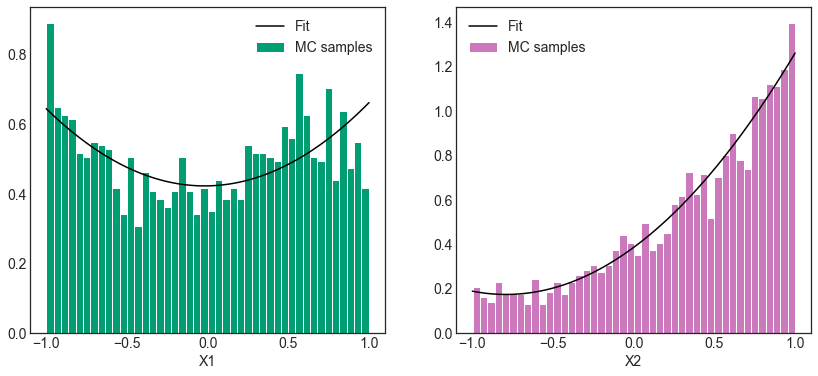

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.hist(x1, bins = 44, density = True, color=color[2], label = 'MC samples') 
ax1.plot(xrange, likelihood(xrange, par1[0], par1[1]), color = 'black', label = 'Fit')
ax1.set_xlabel('X1')
ax1.legend()

ax2.hist(x2, bins = 44, density = True, color=color[4], label = 'MC samples') 
ax2.plot(xrange, likelihood(xrange, par2[0], par2[1]), color = 'black', label = 'Fit')
ax2.set_xlabel('X2')
ax2.legend();

/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_42055/2273438470.py:3: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(likelihood(x, mu, sigma)), axis=1)


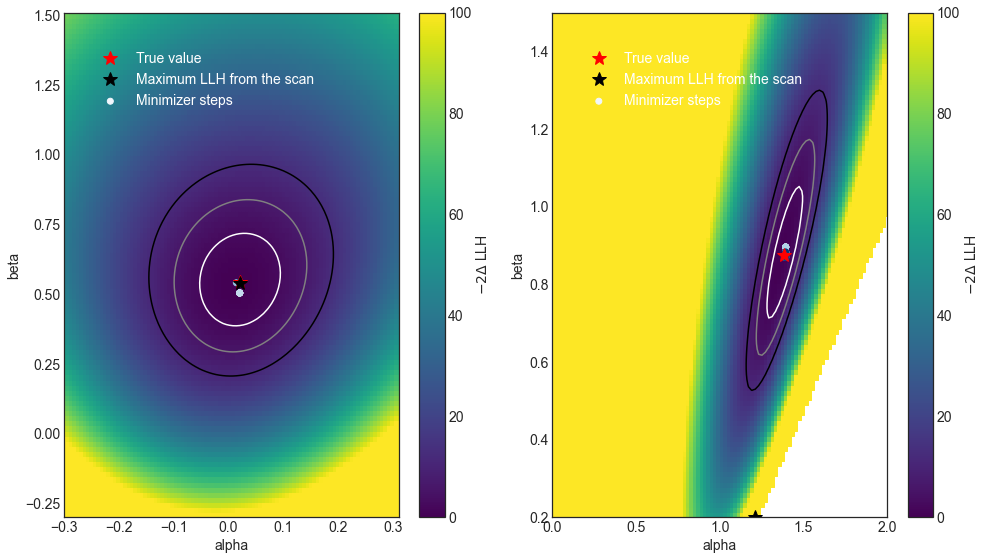

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,8), tight_layout=True)
rasterscan(x1, par1[0], par1[1], alpha_range1, beta_range1, 'alpha', 'beta', ax1)
track_colors = sns.color_palette('Blues',len(alpha_step1))
ax1.scatter(alpha_step1, beta_step1, color = track_colors, label = 'Minimizer steps')
ax1.legend(loc = (0.08,0.8), labelcolor='w')

rasterscan(x2, par2[0], par2[1], alpha_range2, beta_range2, 'alpha', 'beta', ax2)
track_colors = sns.color_palette('Blues',len(alpha_step2))
ax2.scatter(alpha_step2, beta_step2, color = track_colors, label = 'Minimizer steps')
ax2.legend(loc = (0.08,0.8), labelcolor='w');

### Chi2 fit for binned data

In [192]:
N_bins = 44

xmin, xmax = -1, 1
binwidth = (xmax-xmin)/N_bins
N = len(x1)/binwidth

def likelihood_binned(x, N, alpha, beta):
    '''New likelihood that takes N as a parameter in order to fit histogram'''
    func = 1 + alpha*x + beta*x**2 
    func_int = 2+(2*beta/3) 
    pdf = func / func_int
    pdf = np.where(np.abs(x) <= 1, pdf, 0.) 
    return N * binwidth * pdf

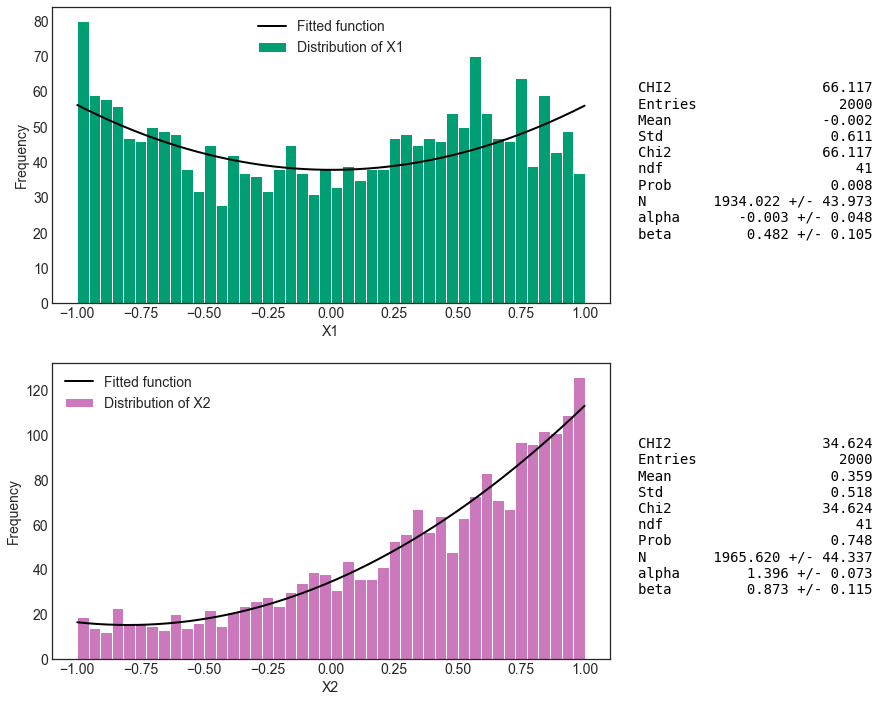

In [193]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,12))
aas.chisquarefit_histogram(x1, likelihood_binned, [N1, alpha_guess1, beta_guess1], xmin, xmax, N_bins, ax1, plot=True,  
                       xlabel='X1', histlabel='Distribution of X1', funclabel='Fitted function', d_xy=[1.05, 0.75],
                       color=color[2])

aas.chisquarefit_histogram(x2, likelihood_binned, [N2, alpha_guess2, beta_guess2], xmin, xmax, N_bins, ax2, plot=True,  
                       xlabel='X2', histlabel='Distribution of X2', funclabel='Fitted function', d_xy=[1.05, 0.75],
                       color=color[4]);

### Chi2 value and P value as a function of bins

In [194]:
bins = np.linspace(20,60, 41)

chi1, chi2 = [], []
p1, p2 = [], []

for i in bins:
    binwidth = (xmax-xmin)/int(i)

    def likelihood_binned(x, N, alpha, beta):
        '''New likelihood that takes N as a parameter in order to fit histogram'''
        func = 1 + alpha*x + beta*x**2 
        func_int = 2+(2*beta/3) 
        pdf = func / func_int
        pdf = np.where(np.abs(x) <= 1, pdf, 0.) 
        return N * binwidth * pdf
    
    res1 = aas.chisquarefit_histogram(x1, likelihood_binned, [N1, alpha_guess1, beta_guess1], xmin1, xmax1, int(i), ax1)
    res2 = aas.chisquarefit_histogram(x2, likelihood_binned, [N2, alpha_guess2, beta_guess2], xmin2, xmax2, int(i), ax2)
    chi1.append(res1[0])
    chi2.append(res2[0])
    p1.append(res1[2])
    p2.append(res2[2])

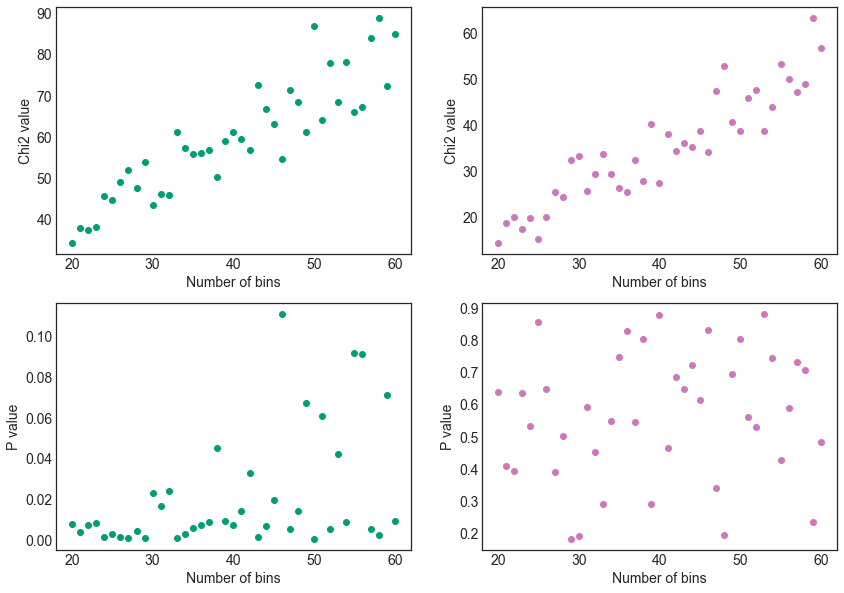

In [187]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14,10))
ax1[0].plot(bins, chi1, 'o', color=color[2])
ax1[0].set_xlabel('Number of bins')
ax1[0].set_ylabel('Chi2 value')
ax1[1].plot(bins, chi2, 'o', color=color[4])
ax1[1].set_xlabel('Number of bins')
ax1[1].set_ylabel('Chi2 value')

ax2[0].plot(bins, p1, 'o', color=color[2])
ax2[0].set_xlabel('Number of bins')
ax2[0].set_ylabel('P value')
ax2[1].plot(bins, p2, 'o', color=color[4])
ax2[1].set_xlabel('Number of bins')
ax2[1].set_ylabel('P value');